# Basic Analysis

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
curr=os.getcwd()
parent_path=os.path.dirname(curr)
data_path=parent_path+'\Dataset'


In [3]:
dataset=pd.read_csv(data_path+'\FineTech_appData.csv')
dataset.head(3)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


* So there are in total 50000 records and only "enrolled_date" is the one which is having missing values

In [12]:
miss_for_noenroll_condition=(dataset['enrolled']==1)&(dataset['enrolled_date'].isnull())
print("Enrolled records without enrolled dates:",len(dataset[miss_for_noenroll_condition]))

Enrolled records without enrolled dates: 0


* Thus we can conclude that there's no missing records

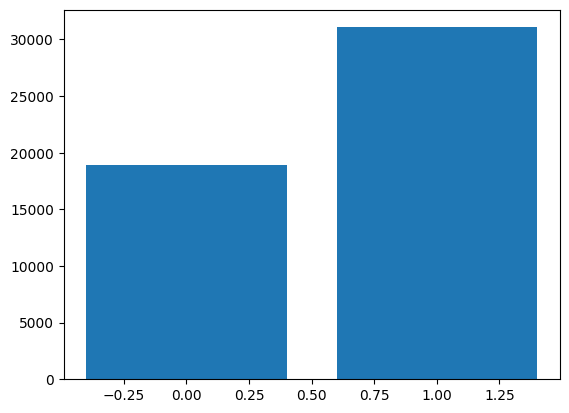

Enrolled vs Not Enrolled
enrolled
1    31074
0    18926
Name: count, dtype: int64


In [24]:
plt.bar(dataset['enrolled'].value_counts().index,dataset['enrolled'].value_counts())
plt.show()
print("Enrolled vs Not Enrolled")
print(dataset['enrolled'].value_counts())


* But we see highly imbalanced data by above graph

In [42]:
dataset['first_open']=pd.to_datetime(dataset['first_open'])
dataset['fdate_numeric']=dataset['first_open'].astype('int64')
dataset['enrolled_date']=pd.to_datetime(dataset['enrolled_date'])
dataset['enrolled_date_numeric']=dataset['enrolled_date'].astype('int64')
dataset['hour']=dataset['hour'].dt.total_seconds()
dataset['hour_numeric']=dataset['hour'].astype('int64')

In [44]:
dataset.head(5)



,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,fdate_numeric,enrolled_date_numeric,hour_numeric
0,235136,2012-12-27 02:14:51.273,3,7200.0,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaT,0,1356574491273000000,-9223372036854775808,7200
1,333588,2012-12-02 01:16:00.905,6,3600.0,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaT,0,1354410960905000000,-9223372036854775808,3600
2,254414,2013-03-19 19:19:09.157,1,68400.0,23,"Splash,Cycle,Loan",3,0,1,0,NaT,1,1363720749157000000,-9223372036854775808,68400
3,234192,2013-07-05 16:08:46.354,4,57600.0,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0,1373040526354000000,1373040709513000000,57600
4,51549,2013-02-26 18:50:48.661,1,64800.0,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1,1361904648661000000,1361904997841000000,64800
